# Case 2 - Diabetic Retinopathy Analysis

Saana Vallius

Last edited: 8.3.2018

### 1. Objectives

The goal for this assignment was to build and train a 2D-convolutional network able to classify fundus images between healthy and affected with diabetic retinopathy. Additionally, the goal is to use advanced metrics to observe the performance of the model in various ways.

### 2. Required imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

Using TensorFlow backend.


In [2]:
#We'll check the matplotlib version, as there were errors using version 2.1.0
import matplotlib
matplotlib.__version__

'2.1.0'

### 3. Data description and preprocessing

In [3]:
#Tony Kuitunen 19.2.2018:
def showsamples(img1, img2):
    plt.figure()
    imgplot = plt.imshow(img1)
    plt.figure()
    imgplot = plt.imshow(img2)
    plt.show()
    return;

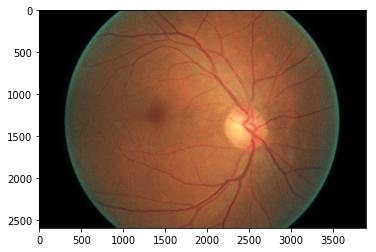

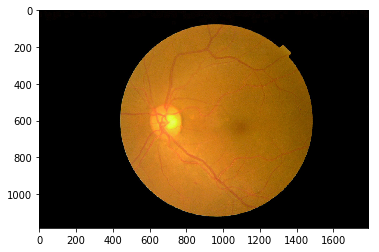

In [4]:
#Plot some example images from the training set
img1=mpimg.imread("dataset2\\train\\nosymptoms\\1324_left.jpeg")
img2=mpimg.imread("dataset2\\train\\symptoms\\1050_left.jpeg")
showsamples(img1,img2)

#These image flags are changed to fight an error caused by the images being loaded as read-only
img1.flags.writeable = True
img2.flags.writeable = True

The preprocessing function created for this assignment follows the code by Sakari Lukkarinen & Juha Kopu, Feb 15, 2018. In the function, the red channel is zeroed out while the green channel is exaggarated. This function was designed by following the principles in this article http://www.opsweb.org/?page=monochromatic by Timothy J. Bennett.

In [5]:
def image_preprocessing_func(x):
    r = x[:, :, 0]
    g = x[:, :, 1]
    b = x[:, :, 2]
    
    g = (g - np.mean(g))/(1.0*np.std(g));
    b = (b - np.mean(b))/(1.0*np.std(b));
  
    x[:, :, 0] = r*0
    x[:, :, 1] = g*60+20
    x[:, :, 2] = b
    
    return x

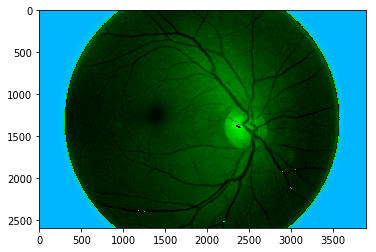

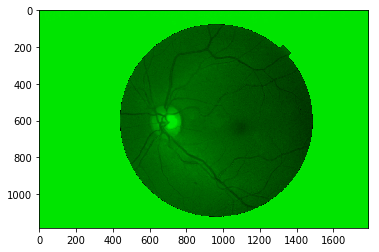

In [6]:
#Preprocessed images
img1=mpimg.imread("dataset2\\train\\nosymptoms\\1324_left.jpeg")
img2=mpimg.imread("dataset2\\train\\symptoms\\1050_left.jpeg")
img1.flags.writeable = True
img2.flags.writeable = True
img1 = image_preprocessing_func(img1)
img2 = image_preprocessing_func(img2)

showsamples(img1,img2)

In [7]:
train_dir = ".\\dataset2\\train"
validation_dir = ".\\dataset2\\validation"
test_dir = ".\\dataset2\\test"


train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = image_preprocessing_func)
validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = image_preprocessing_func)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = image_preprocessing_func)

train_generator = train_datagen.flow_from_directory(train_dir, 
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 1237 images belonging to 2 classes.
Found 413 images belonging to 2 classes.
Found 413 images belonging to 2 classes.
data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


### 4. Modeling and compilation

In [8]:
#Build the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [9]:
#Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

### 5. Training and validation

In [10]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=62, #samples/batch size if there's no augmented data (62)
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=21)

Epoch 1/10
62/62 [==============================] - 696s 11s/step - loss: 0.6290 - acc: 0.7106 - val_loss: 0.5720 - val_acc: 0.7119
Epoch 2/10
62/62 [==============================] - 598s 10s/step - loss: 0.5488 - acc: 0.7177 - val_loss: 0.4960 - val_acc: 0.7385
Epoch 3/10
62/62 [==============================] - 577s 9s/step - loss: 0.5345 - acc: 0.7217 - val_loss: 0.5035 - val_acc: 0.7821
Epoch 4/10
62/62 [==============================] - 582s 9s/step - loss: 0.5128 - acc: 0.7409 - val_loss: 0.4728 - val_acc: 0.7676
Epoch 5/10
62/62 [==============================] - 556s 9s/step - loss: 0.5006 - acc: 0.7441 - val_loss: 0.4546 - val_acc: 0.7821
Epoch 6/10
62/62 [==============================] - 565s 9s/step - loss: 0.4916 - acc: 0.7409 - val_loss: 0.4658 - val_acc: 0.7821
Epoch 7/10
62/62 [==============================] - 567s 9s/step - loss: 0.4681 - acc: 0.7473 - val_loss: 0.4535 - val_acc: 0.7676
Epoch 8/10
62/62 [==============================] - 553s 9s/step - loss: 0.4591 -

In [11]:
#Save the model for later use
model.save('final.h10')

### 6. Evaluation

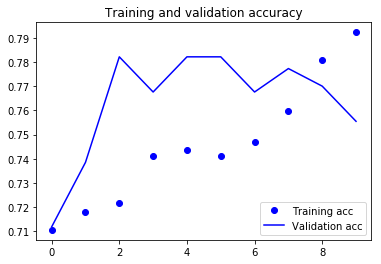

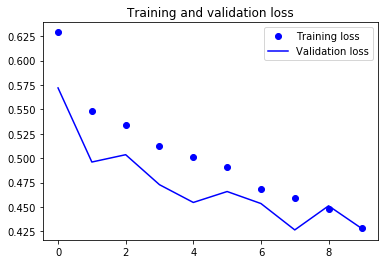

In [12]:
#Save the required metrics into variables
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Plot the accuracies
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Plot the losses
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
#Calculate the final result
result = model.evaluate_generator(test_generator, steps = 21)

In [13]:
# Loss and accuracy
print("Final result:\n Accuracy:", result[1], "Loss:", result[0])

Final result:
 Accuracy: 0.782082323012 Loss: 0.415350646574


Several models were tried out while solving the problem. The best models all reached validation accuracies varying between 75 and 80 percent. With deeper, more complicating models the execution time quickly increases even though the results aren't improving. Adding more layers actually made the results drop even earlier, so a simple model was determined to be the best one.

At least these methods were tried while trying to improve the results:
* Changing the amount of epochs (5-50)
* Changing the batch size
* Decreasing the amount of validation steps (with and without data augmentation)
* Adding more convolutional layer
* Adding more dense layers
* Altering filter dimensions
* Data augmentation
* Trying out several preprocessing functions

Most of these modifications only made the results worse.

The sole things that helped were:
1. Finding a suitable preprocessing function through research
2.


### 7. Results

In [14]:
y_true = np.zeros(413)
y_score = np.zeros(413)
sample_count = 413
i = 0
for inputs_batch, labels_batch in test_generator:
        predicts_batch = model.predict(inputs_batch)
        L = labels_batch.shape[0]
        index = range(i, i + L)
        y_true[index] = labels_batch.ravel()
        y_score[index] = predicts_batch.ravel()
        i = i + L
        if i >= sample_count:
            break

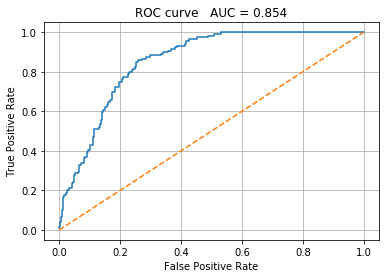

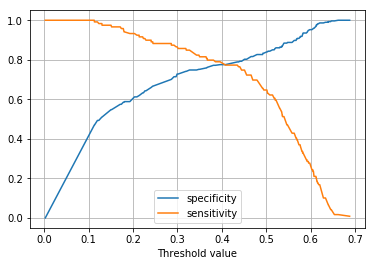

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve   AUC = {:.3f}'.format(auc))
plt.show()

plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [36]:
# Select the threshold to maximize both specificity and sensitivity
th = 0.37

# Select the threshold to maxim
acc = accuracy_score(y_true, y_score > th)
prec = precision_score(y_true, y_score > th)
f1 = f1_score(y_true, y_score > th)
recall = recall_score(y_true, y_score > th)

print('Accuracy:  {:.3f}'.format(acc))
print('Precision: {:.3f}'.format(prec))
print('Recall:    {:.3f}'.format(recall))
print('F1:        {:.3f}'.format(f1))

Accuracy:  0.777
Precision: 0.583
Recall:    0.798
F1:        0.674


In [37]:
print('Classification report')
print(classification_report(y_true, y_score > th, labels = [1.0, 0.0], target_names = ['Disease', 'Healthy']))

Classification report
             precision    recall  f1-score   support

    Disease       0.58      0.80      0.67       119
    Healthy       0.90      0.77      0.83       294

avg / total       0.81      0.78      0.79       413



In [48]:
tn, fp, fn, tp = confusion_matrix(y_true, y_score > th).ravel()

print('                      Confusion matrix\n')
print('                       True condition')
print('                      ----------------')
print('                      Positive Negative      Sum')
print('Predicted | Positive  {:8} {:8} {:8}'.format(tp, fp, tp + fp))
print('condition | Negative  {:8} {:8} {:8}'.format(fn, tn, fn + tn))
print('                 Sum  {:8} {:8} {:8}'.format(tp + fn, fp + tn, tp + fp + fn + tn))
print(' ')
print('Sensitivity: {:.3f}'.format(tp/(tp+fn)))
print('Specificity: {:.3f}'.format(tn/(tn+fp)))

                      Confusion matrix

                       True condition
                      ----------------
                      Positive Negative      Sum
Predicted | Positive        95       68      163
condition | Negative        24      226      250
                 Sum       119      294      413
 
Sensitivity: 0.798
Specificity: 0.769


### 8. Conclusions

The accuracy of the model calculated from the evaluation of the test set 78% is quite good. The accuracy calculated by adding the amount of true positive predictions to the amount of true negative predictions and divided by the total amount of cases, 77%, supports the reliability of the result.

The sensitivity or recall of the model, 79.8%, shows the percentage of images classified correctly as suffering from diabetic retinopathy. On the other hand, the specificity rate, 76.9% measures how many of the images of healthy retina are predicted to be healthy. Sensitivity can be calculated by dividing the amount of true positives by all true positives added to false negatives, whereas the specificity is counted by dividing the amout of true negative by all true negatives added to false positives. Another metric, precision of 58%, has been computed by dividing the true positives with all positive predictions and determines how many of the cases determined as affected were relevant.

The threshold value for maximazing both the sensitivity and specificity values has been handpicked by analysing the plotted ROC curve and accompanied threshold plot. The ROC or receiver operating characteristic curve estimates how well the model performs as a binary classifier. The closer the curve gets to the top left corner of the grid, the better the model is.

#### Issues

A myriad of problems raised when working on the assignment, mostly linking to Anaconda and its packages. The first issue was that the preprocessing function did not work, because Python found the images to be read-only. This made modifying the RGB values of the image arrays impossible. I checked the permissions on the images residing in the home directory of the user for which Anaconda is also installed, but couldn't find the problem. In Windows the permissions were as they should be. A way around this was to manually change the 'writable' flags of the images to True.

Later there was also difficulty in merely printing the images, as the environment had somehow lost its connection to the pillow (PIL) library and refused to function. I tried installing and uninstalling different versions of the package through various way, yet nothing worked.

On two separate occasions Anaconda became so corrupted, that it could no longer solve its environments at all, so installing and uninstalling packages and managing the conda installation became impossible. I had to uninstall and reinstall the whole Anaconda Python distribution more than once, occasionally having to dispose of some of its files manually. 

Additionally, my laptop kept rebooting unexpectedly while running epochs. This however tells more about my laptop and the fact that a cheap, old computer isn't the way to go when training 2D-convnets and deep learning models.

Solving these errors took significant amounts of time, which was off from actual work on the assignment.

#### Improvements

The most interesting thing about the model itself is, that is uses an image preprocessing function which practically only uses two of the RGB channels, the green and blue channels. I also tried to use the green channel only, and the results were very close to those of the two-channel version. If there would be a way to truly use only 1 or 2 of the channels making the dimensions of the first layer of the model height x width x 1 or height x width x 2, the amount of parameters in the model would be lower. This would assumably significantly decrease computation time, thus lead to as good results with much less effort. The use of less channels, however, doesn't unfortunately work with the image data generators used in this assignment.

One way of benefitting from this principle could be by experimenting with using convolutions that are separately applied to each RGB channel. This way it might be possible to only pick the relevant channel(s) for later use.

Another possible improvement could be a specific kind of data augmentation. The dataset consists of half as many healthy images as affected ones. Data augmentation could be used to oversample diseased cases in such way that the sizes of each group could be the same. This way the classification of diseased individuals especially could be improved.

All in all, the results are quite satisfying for such a small model. It seems however that there's still a lot to learn about convolutional networks and how they behave and evolve when their different hyperparameters are changed.